In [1]:
from IPython.core.interactiveshell import InteractiveShell  #执行该代码可以使得当前nb支持多输出
InteractiveShell.ast_node_interactivity = "all" 
import numpy as np
from datetime import datetime
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
pd.options.display.max_rows = 8  
%matplotlib inline

import os, sys
import statsmodels, arch

print(sys.version)
print('statsmodels version: ',statsmodels.__version__, 
    '; arch version: ', arch.__version__)

3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
statsmodels version:  0.12.0 ; arch version:  4.19


读取数据

In [2]:
national_debt = pd.read_csv('data/national_debt_5y.csv',header=0,index_col = 0,encoding = 'gb2312')  # 读取股票文件
national_debt['涨跌幅'] = national_debt['涨跌幅'].str.strip("%").astype(float)/100
national_debt.head()
national_debt.describe()

开盘     收盘      高      低     涨跌幅
日期                                           
2016/1/21  2.683  2.700  2.703  2.680  0.0078
2016/1/22  2.705  2.689  2.705  2.682 -0.0041
2016/1/25  2.750  2.694  2.750  2.680  0.0019
2016/1/26  2.703  2.738  2.740  2.690  0.0163
2016/1/27  2.763  2.774  2.783  2.763  0.0131

开盘           收盘            高            低           涨跌幅
count  1563.000000  1563.000000  1563.000000  1563.000000  1.563000e+03
mean      3.041862     3.022280     3.049060     3.010074  4.478567e-07
std       0.419688     0.420101     0.418939     0.420670  9.475657e-03
min       1.740000     1.740000     1.740000     1.740000 -5.850000e-02
25%       2.746000     2.712000     2.750000     2.697000 -4.350000e-03
50%       3.012000     2.993000     3.018000     2.983000  0.000000e+00
75%       3.261000     3.234000     3.269000     3.219000  4.300000e-03
max       4.000000     3.968000     4.000000     3.952000  6.070000e-02

单位根检验

In [3]:
from arch.unitroot import ADF
print(ADF(national_debt.开盘))

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.162
P-value                         0.220
Lags                               21
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


p-value大于0.1，拒绝了序列 x 的平稳性。

In [4]:
#可以看到序列自相关性是很高的，从序列表现来看也不够平稳性，所以需要做一阶差分
data = pd.Series(np.diff(national_debt.开盘))
#data = pd.Series.diff(national_debt.开盘)
print("data length is %d",len(data))

print(ADF(data))

data length is %d 1562
   Augmented Dickey-Fuller Results   
Test Statistic                 -6.791
P-value                         0.000
Lags                               20
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


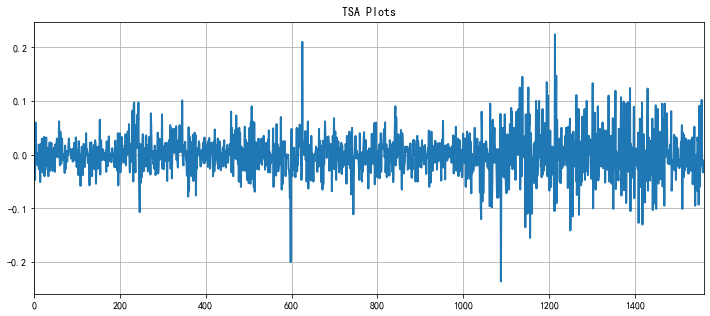

In [5]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

data.plot(use_index=False,figsize=(12,5),linewidth=2,grid=True,title = "TSA Plots")
plt.show()

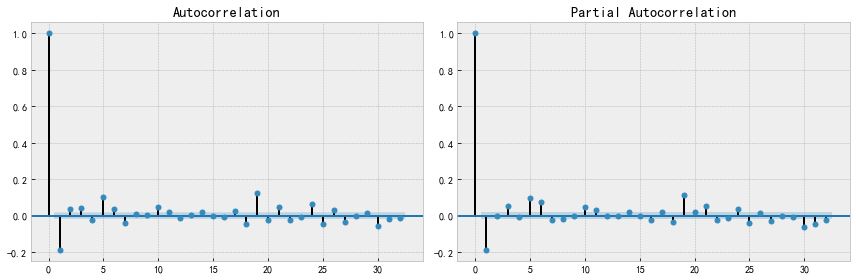

In [6]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

from scipy import stats
from arch.unitroot import ADF

def tsplot(y, lags=None, figsize=(12, 4), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (1, 2)
      
        acf_ax = plt.subplot2grid(layout, (0, 0))
        pacf_ax = plt.subplot2grid(layout, (0, 1))
         
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        
        plt.tight_layout()

tsplot(data)

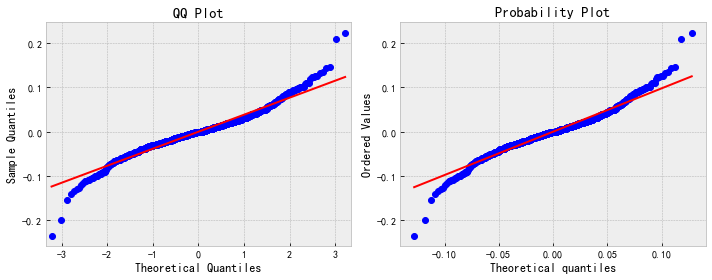

In [7]:
def tsplot2(y, lags=None, figsize=(10,4), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (1, 2)
        qq_ax = plt.subplot2grid(layout, (0, 0))
        pp_ax = plt.subplot2grid(layout, (0, 1))
        
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        stats.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        
        plt.tight_layout()

tsplot2(data)

QQ plot（quantile-quantile plot），也称正态概率图（normal probability plot），分位数-分位数图,是常用的统计分析用图，
用于检查一组数据是否服从正态分布，是实数与正态分布数据间的函数关系的散点图。
如果这组实数服从正态分布，正态概率图就是一条直线。通常，概率图也可用于确定一组数据是否服从任一已知分布，如二项分布或泊松分布。

p–p图绘制两个累积分布函数（CDF）的相对位置：这是一个概率图，用于评估两个数据集之间的一致程度，
并绘制两个累积分布函数的相对位置。P-P图被广泛用于评估分布的偏斜度。

截尾是指时间序列的自相关函数（ACF）或偏自相关函数（PACF）在某阶后均为0的性质，在大于某个常数k后快速趋于0为k阶截尾；

拖尾是ACF或PACF并不在某阶后均为0的性质，始终有非零取值，不会在k大于某个常数后就恒等于零(或在0附近随机波动)。

AR模型：自相关系数拖尾，偏自相关系数截尾；

MA模型：自相关系数截尾，偏自相关函数拖尾；

ARMA模型：自相关函数和偏自相关函数均拖尾。


## ARMA 模型

In [8]:
# 移动平均图
def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size).mean()
    # 对size个数据进行加权移动平均
    rol_weighted_mean = pd.DataFrame.ewm(timeSeries, span=size).mean()

    timeSeries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()

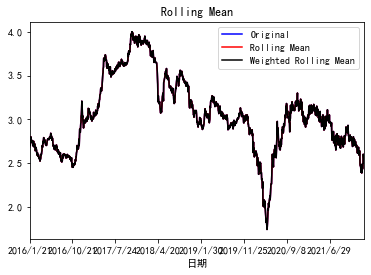

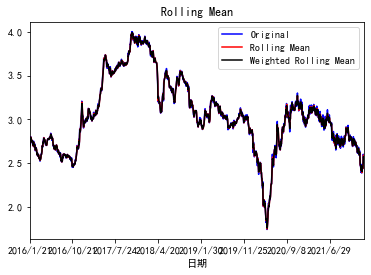

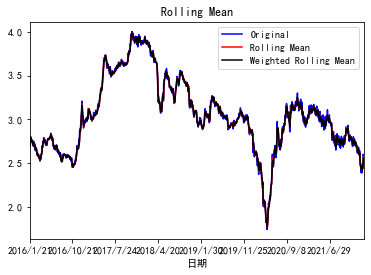

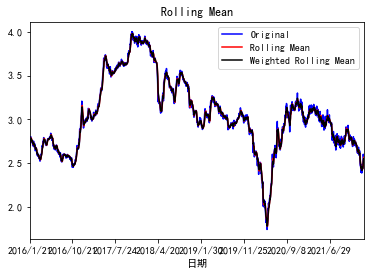

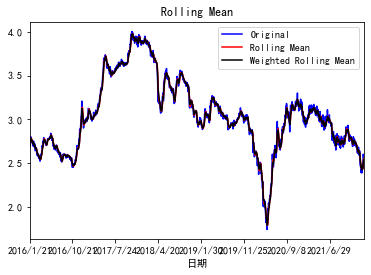

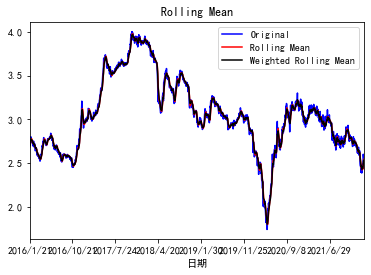

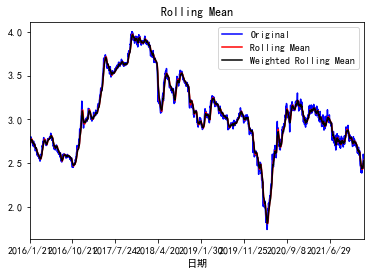

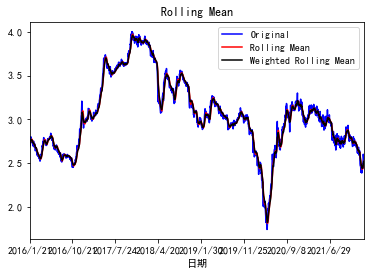

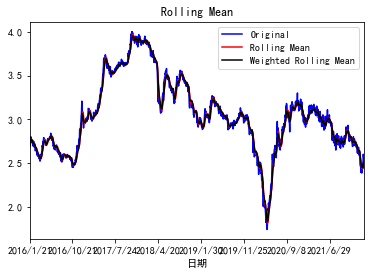

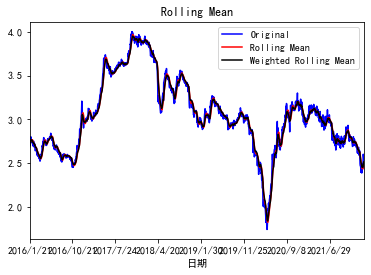

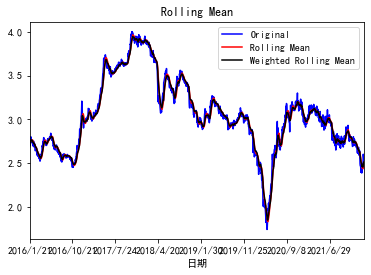

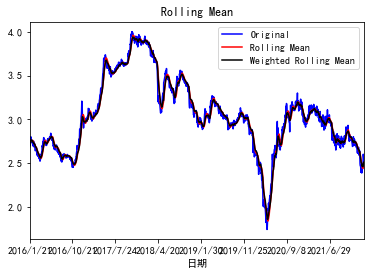

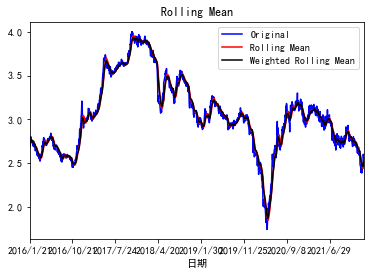

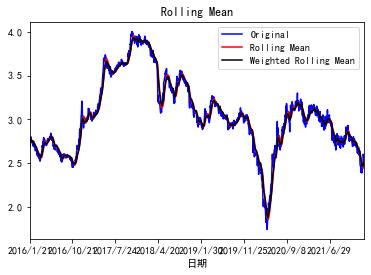

In [9]:
for i in range(1,15):
    
    draw_trend(national_debt.开盘, i)


In [10]:
from statsmodels.tsa.stattools import adfuller
def testStationarity(ts):
    dftest = adfuller(ts)
    print(dftest)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

ts_log = np.log(national_debt.开盘)
print("检验取对数后的平稳性 \n")
testStationarity(ts_log)
ts_diff_1 = ts_log.diff(1)
ts_diff_1.dropna(inplace=True)
print("检验取对数差分后的平稳性 \n")
testStationarity(ts_diff_1)

检验取对数后的平稳性 

(-2.507011306652641, 0.11377770493442663, 21, 1541, {'1%': -3.4346006335993753, '5%': -2.8634173941776297, '10%': -2.5677694956796304}, -8964.904587723766)


Test Statistic                   -2.507011
p-value                           0.113778
#Lags Used                       21.000000
Number of Observations Used    1541.000000
Critical Value (1%)              -3.434601
Critical Value (5%)              -2.863417
Critical Value (10%)             -2.567769
dtype: float64

检验取对数差分后的平稳性 

(-6.628276405192234, 5.801469701718804e-09, 24, 1537, {'1%': -3.4346117143132786, '5%': -2.8634222847534607, '10%': -2.567772099925964}, -8957.413745798414)


Test Statistic                -6.628276e+00
p-value                        5.801470e-09
#Lags Used                     2.400000e+01
Number of Observations Used    1.537000e+03
Critical Value (1%)           -3.434612e+00
Critical Value (5%)           -2.863422e+00
Critical Value (10%)          -2.567772e+00
dtype: float64

差分后，ADF检验中p值为0.000小于0.05，故而差分后序列平稳。

In [11]:
from statsmodels.tsa import ar_model

# AIC 准则，最大阶数 10\
est = ar_model.ar_select_order(national_debt.开盘, maxlag=10, ic='aic', trend='ct', glob=True)
est.aic
est.model
print(est.ar_lags)

D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


{(1, 2, 5, 7): -6.563813420223033,
 (1, 2, 5, 6, 7): -6.563460986863056,
 (1, 2, 5, 7, 9): -6.563105466492261,
 (1, 2, 3, 5, 7): -6.563104619079304,
 (1, 2, 5, 6, 7, 9): -6.56298174229641,
 (1, 2, 5, 7, 8): -6.562938696968743,
 (1, 2, 5, 7, 10): -6.562922910496433,
 (1, 2, 3, 5, 6, 7): -6.56289339014096,
 (1, 2, 5, 6, 7, 8): -6.562829644230572,
 (1, 2, 4, 5, 7): -6.562829058494229,
 (1, 2, 5, 6, 7, 10): -6.562687390552746,
 (1, 2, 3, 4, 5, 7): -6.562651666945645,
 (1, 2, 4, 5, 6, 7): -6.5623647585272415,
 (1, 2, 3, 5, 6, 7, 9): -6.5623542815497435,
 (1, 2, 3, 5, 7, 9): -6.562339370763378,
 (1, 2, 3, 4, 5, 6, 7): -6.562277213820391,
 (1, 2, 3, 5, 7, 10): -6.562232582476695,
 (1, 2, 4, 5, 7, 9): -6.562185705323164,
 (1, 2, 3, 5, 6, 7, 8): -6.562169050492401,
 (1, 2, 3, 5, 6, 7, 10): -6.5621531718097845,
 (1, 2, 3, 5, 7, 8): -6.562152985565693,
 (1, 2, 4, 5, 7, 8): -6.561971285049083,
 (1, 2, 3, 4, 5, 7, 9): -6.561964316616028,
 (1, 2, 4, 5, 7, 10): -6.561940879503997,
 (1, 2, 4, 5, 6, 7,

[1 2 5 7]


白噪声检验

In [12]:
from statsmodels.stats.diagnostic import acorr_ljungbox
res = acorr_ljungbox(ts_diff_1, lags=[6,12,24], return_df=True)
print(res)

       lb_stat     lb_pvalue
6    74.352689  5.216453e-14
12   80.102678  3.945309e-12
24  116.999788  3.309938e-14


各滞后期数下p值都为0均小于0.05，差分后的序列非白噪声，可以进行预测。

In [12]:
from statsmodels.tsa.stattools import arma_order_select_ic
bic_min_order = arma_order_select_ic(ts_diff_1, max_ar=6, max_ma=5, ic='bic')['bic_min_order']
print(bic_min_order)

D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  

(1, 4)


D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [73]:
import statsmodels.tsa.api as smt
smt.arma_order_select_ic(ts_log, ic='aic', trend='c')

D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


{'aic':              0            1            2
 0 -1704.829375 -3653.891467 -4990.943648
 1 -9038.335527 -9079.813060 -9081.264659
 2 -9082.000924 -9080.003886 -9066.722377
 3 -9080.005886 -9082.900619 -9085.369983
 4 -9083.128851 -9083.041622 -9094.195550, 'aic_min_order': (4, 2)}

In [13]:
from statsmodels.tsa.arima.model import ARIMA
ts_log = ts_log.tolist()
train,test = ts_log[:len(ts_log) - 300], ts_log[len(ts_log) - 300 :]

arima = ARIMA(train, order=(1, 1,5)) #, trend="ct"
result_arima = arima.fit()
result_arima.summary()

D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1263
Model:                 ARIMA(1, 1, 5)   Log Likelihood                3757.636
Date:                Fri, 15 Apr 2022   AIC                          -7501.272
Time:                        17:29:49   BIC                          -7465.289
Sample:                             0   HQIC                         -7487.751
                               - 1263                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4484      0.139      3.225      0.001       0.176       0.721
ma.L1         -0.5584      0.136     -4.096      0.000      -0.826      -0.291
ma.L2          0.1466      0.026      5.696      0.000       0.096       0.197
ma.L3          0.0138      0.027      0.505      0.613      -0.040       0.067
ma.L4         -0.0844      0.025     -3.403      0.001      -0.133      -0.036
ma.L5          0.1335      0.021      6.233      0.000       0.092       0.175
sigma2         0.0002   3.09e-06     49.549      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              2724.43
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               3.22   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

系数p值均小于0.05，说明系数均显著不为0。如果存在某个系数的p值较大，说明t检验中系数不显著，贡献不大，可以剔除，减小模型冗余度。

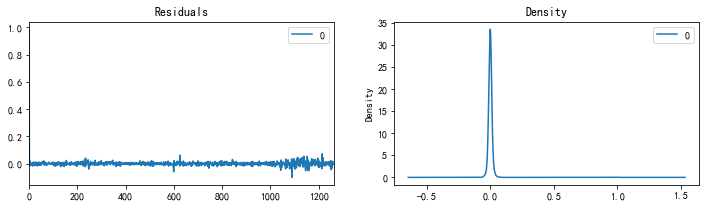

In [14]:
# Plot residual errors
residuals = pd.DataFrame(result_arima.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0],figsize=(12,3))
residuals.plot(kind='kde', title='Density', ax=ax[1],figsize=(12,3))
plt.show()

In [140]:
predict_ts_arima = result_arima.predict()
print(predict_ts_arima)
print("the length of predict_ts is %d ",len(predict_ts_arima))

log_recover = np.exp(predict_ts_arima)
log_recover.dropna(inplace=True)
print("the length of log_recover is %d ",len(log_recover))

日期
2016/1/21    0.000000
2016/1/22    0.986936
2016/1/25    0.993670
2016/1/26    1.008915
               ...   
2022/1/21    0.902491
2022/1/24    0.903193
2022/1/25    0.899787
2022/1/26    0.872911
Name: predicted_mean, Length: 1548, dtype: float64
the length of predict_ts is %d  1548
the length of log_recover is %d  1548


In [22]:
forecast_result, resid_test = [], []
history = train
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,5))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    forecast_result.append(yhat)
    resid_test.append(test[t] - output[0])

    history.append(test[t])
    print('predicted=%f, expected=%f' % (yhat, test[t]))

predicted=0.918546, expected=1.153100
predicted=1.109461, expected=1.137512
predicted=1.138031, expected=1.172482
predicted=1.172658, expected=1.148988
predicted=1.146512, expected=1.138474
predicted=1.162817, expected=1.136550
predicted=1.150419, expected=1.135587
predicted=1.146436, expected=1.162526
predicted=1.163023, expected=1.126876
predicted=1.134823, expected=1.117761
predicted=1.117456, expected=1.112844
predicted=1.109232, expected=1.120048
predicted=1.119453, expected=1.128171
predicted=1.124740, expected=1.109552
predicted=1.109562, expected=1.104926
predicted=1.102651, expected=1.088225
predicted=1.090056, expected=1.111858
predicted=1.108970, expected=1.102604
predicted=1.103818, expected=1.092930
predicted=1.094051, expected=1.089572
predicted=1.087085, expected=1.078410
predicted=1.081033, expected=1.106911
predicted=1.102499, expected=1.091252
predicted=1.093456, expected=1.085865
predicted=1.086014, expected=1.075344
predicted=1.074455, expected=1.068153
predicted=1.

D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=1.108163, expected=1.088225
predicted=1.093471, expected=1.088562
predicted=1.087407, expected=1.086540
predicted=1.084596, expected=1.084513


D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=1.087737, expected=1.088562
predicted=1.087515, expected=1.081805
predicted=1.081991, expected=1.079769
predicted=1.079468, expected=1.080448
predicted=1.079944, expected=1.071241
predicted=1.073063, expected=1.085189
predicted=1.082018, expected=1.041336
predicted=1.048973, expected=1.036737
predicted=1.037352, expected=1.015231
predicted=1.017429, expected=1.039216
predicted=1.036149, expected=1.049422
predicted=1.044403, expected=1.028190
predicted=1.029440, expected=1.028190
predicted=1.023558, expected=1.016317


D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=1.018186, expected=1.050822
predicted=1.046697, expected=1.004302
predicted=1.012829, expected=1.007228
predicted=1.005935, expected=1.017041
predicted=1.012965, expected=1.030690
predicted=1.031959, expected=1.025324
predicted=1.024024, expected=1.025324
predicted=1.022640, expected=0.992881
predicted=0.998682, expected=0.995841
predicted=0.997277, expected=0.997318
predicted=0.997386, expected=0.992140
predicted=0.993999, expected=0.973805
predicted=0.974321, expected=0.992140
predicted=0.986382, expected=1.036737
predicted=1.027701, expected=1.012691
predicted=1.017158, expected=1.023529
predicted=1.018721, expected=1.034962
predicted=1.032074, expected=1.042042
predicted=1.046778, expected=1.026042
predicted=1.030732, expected=1.008688
predicted=1.012531, expected=1.009781
predicted=1.011265, expected=0.996210
predicted=1.001073, expected=1.006131
predicted=1.003543, expected=1.009052
predicted=1.005537, expected=1.033184
predicted=1.027236, expected=0.995841
predicted=1.

D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=0.994179, expected=0.985070
predicted=0.986676, expected=1.018847
predicted=1.011619, expected=0.981704
predicted=0.990471, expected=1.003935
predicted=0.997734, expected=1.001734
predicted=0.998847, expected=1.000632
predicted=1.003855, expected=1.031404
predicted=1.023555, expected=1.011964
predicted=1.015909, expected=1.013417
predicted=1.014064, expected=1.024248
predicted=1.021828, expected=1.013780
predicted=1.019157, expected=0.996949
predicted=1.000855, expected=1.012691
predicted=1.008878, expected=1.001734
predicted=1.004743, expected=1.003569
predicted=1.003620, expected=0.986936
predicted=0.987320, expected=1.021731
predicted=1.014791, expected=1.000264
predicted=1.003960, expected=1.002101
predicted=1.001967, expected=1.009052
predicted=1.004862, expected=1.033184
predicted=1.030987, expected=0.998792
predicted=1.006019, expected=1.033184
predicted=1.025842, expected=1.032829
predicted=1.032554, expected=1.031404
predicted=1.035574, expected=1.033540
predicted=1.

D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=1.024226, expected=0.992881
predicted=0.999856, expected=1.007958
predicted=1.005989, expected=1.020651
predicted=1.018861, expected=1.005400
predicted=1.012177, expected=1.018847


D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=1.014712, expected=1.007958
predicted=1.009248, expected=0.998792
predicted=1.002447, expected=0.993252
predicted=0.993753, expected=1.004302
predicted=1.002274, expected=1.009781


D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=1.008268, expected=1.001734
predicted=1.002307, expected=0.998424
predicted=0.997393, expected=0.997686
predicted=0.997827, expected=0.985070
predicted=0.988743, expected=0.995102
predicted=0.993098, expected=0.982078
predicted=0.984035, expected=0.975314
predicted=0.976812, expected=0.966223
predicted=0.966488, expected=0.960499
predicted=0.961632, expected=0.970779
predicted=0.967711, expected=0.959350


D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=0.960306, expected=0.966984
predicted=0.963972, expected=0.973805
predicted=0.970665, expected=0.985817
predicted=0.983794, expected=0.965081
predicted=0.968742, expected=0.953587
predicted=0.956246, expected=0.954742
predicted=0.955132, expected=0.950885
predicted=0.954091, expected=0.970779
predicted=0.966331, expected=0.949726
predicted=0.951908, expected=0.912283
predicted=0.918961, expected=0.903813
predicted=0.904132, expected=0.903813
predicted=0.904974, expected=0.900161
predicted=0.900834, expected=0.872548
predicted=0.873934, expected=0.885832
predicted=0.879241, expected=0.896088
predicted=0.891824, expected=0.907452
predicted=0.904573, expected=0.869199
predicted=0.873627, expected=0.873801
predicted=0.872269, expected=0.911077
predicted=0.904610, expected=0.887068
predicted=0.894573, expected=0.891178
predicted=0.888743, expected=0.892408
predicted=0.889869, expected=0.915490
predicted=0.914133, expected=0.955511
predicted=0.947462, expected=0.947789
predicted=0.

In [28]:
test_resid = resid_test 
forecast_result_recover = []

for i in range(len(forecast_result)):
    forecast_result_recover.append(np.exp(forecast_result[i])) 

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'national debt Price Prediction')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'national debt Price')

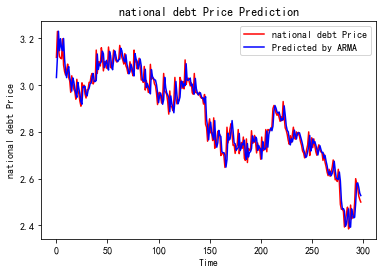

In [31]:
plt.figure(facecolor='white')
# type(national_debt.开盘[len(national_debt.开盘)-300:])
plt.plot(np.array(national_debt.开盘[len(national_debt.开盘)-299:]), color='red', label='national debt Price')
# type(log_recover[len(log_recover) - 300:])
plt.plot(forecast_result_recover[1:], color='blue', label='Predicted by ARMA')
plt.title('national debt Price Prediction')
plt.xlabel('Time')
plt.ylabel('national debt Price')
plt.legend()
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(forecast_result_recover, national_debt.开盘[len(national_debt.开盘)-300:])
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mse)
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(forecast_result_recover, national_debt.开盘[len(national_debt.开盘)-300:])
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

均方误差: 0.003538
均方根误差: 0.059485
平均绝对误差: 0.037234
